# Capstone Project: AI-Based Landing Zone Safety
## Comprehensive Analysis & Safety System

In [1]:
# === IMPORTS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ML Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, roc_curve, confusion_matrix, classification_report)
from sklearn.calibration import CalibrationDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Advanced Models (Optional)
from xgboost import XGBClassifier

try:
    from lightgbm import LGBMClassifier
    LGBM_AVAILABLE = True
except ImportError:
    LGBM_AVAILABLE = False
    print("LightGBM not available")

try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("CatBoost not available")

# SMOTE for class balancing
from imblearn.over_sampling import SMOTE

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [12, 8]
COLORS = {'safe': '#2ecc71', 'unsafe': '#e74c3c', 'primary': '#3498db'}
print("✅ All libraries loaded!")

✅ All libraries loaded!


## 1. Data Loading & Inspection

In [2]:
# Load Data
df = pd.read_excel("Landing Zone Dataset.xlsx")
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(inplace=True)

print(f"✅ Loaded {len(df)} samples")
display(df.head())
print(f"\n📊 Class Distribution:\n{df['label'].value_counts()}")

✅ Loaded 3000 samples


,slope_deg,roughness,edge_density,ndvi_mean,shadow_fraction,brightness_std,object_density,confidence_score,label
0,10.483571,0.066756,0.099523,0.398224,0.297286,0.067727,0.182327,0.741485,1
1,7.308678,0.105711,0.377215,0.669015,0.057829,0.147740,0.272118,0.837913,1
2,11.238443,0.535800,0.067437,0.438767,0.198451,0.132821,0.140229,0.802620,0
3,15.615149,0.159571,0.182308,0.081362,0.379600,0.124568,0.170602,0.777006,1
4,6.829233,0.122880,0.129803,0.492456,0.110414,0.156328,0.044424,0.885057,1



📊 Class Distribution:
label
1    1650
0    1350
Name: count, dtype: int64


## 2. Exploratory Data Analysis (EDA)

📊 Descriptive Statistics:


,mean,std,min,50%,max
slope_deg,8.257786,4.729597,0.000000,8.121824,27.631189
roughness,0.287347,0.157635,0.005368,0.266516,0.819733
edge_density,0.335261,0.176202,0.000868,0.319744,0.901881
ndvi_mean,0.397403,0.229965,0.000004,0.398755,0.799831
shadow_fraction,0.245188,0.142418,0.005999,0.224382,0.756748
brightness_std,0.151231,0.050393,-0.018778,0.151421,0.314608
object_density,0.219207,0.130930,0.004051,0.196254,0.765969
confidence_score,0.775345,0.100204,0.600259,0.776927,0.949867
label,0.550000,0.497577,0.000000,1.000000,1.000000


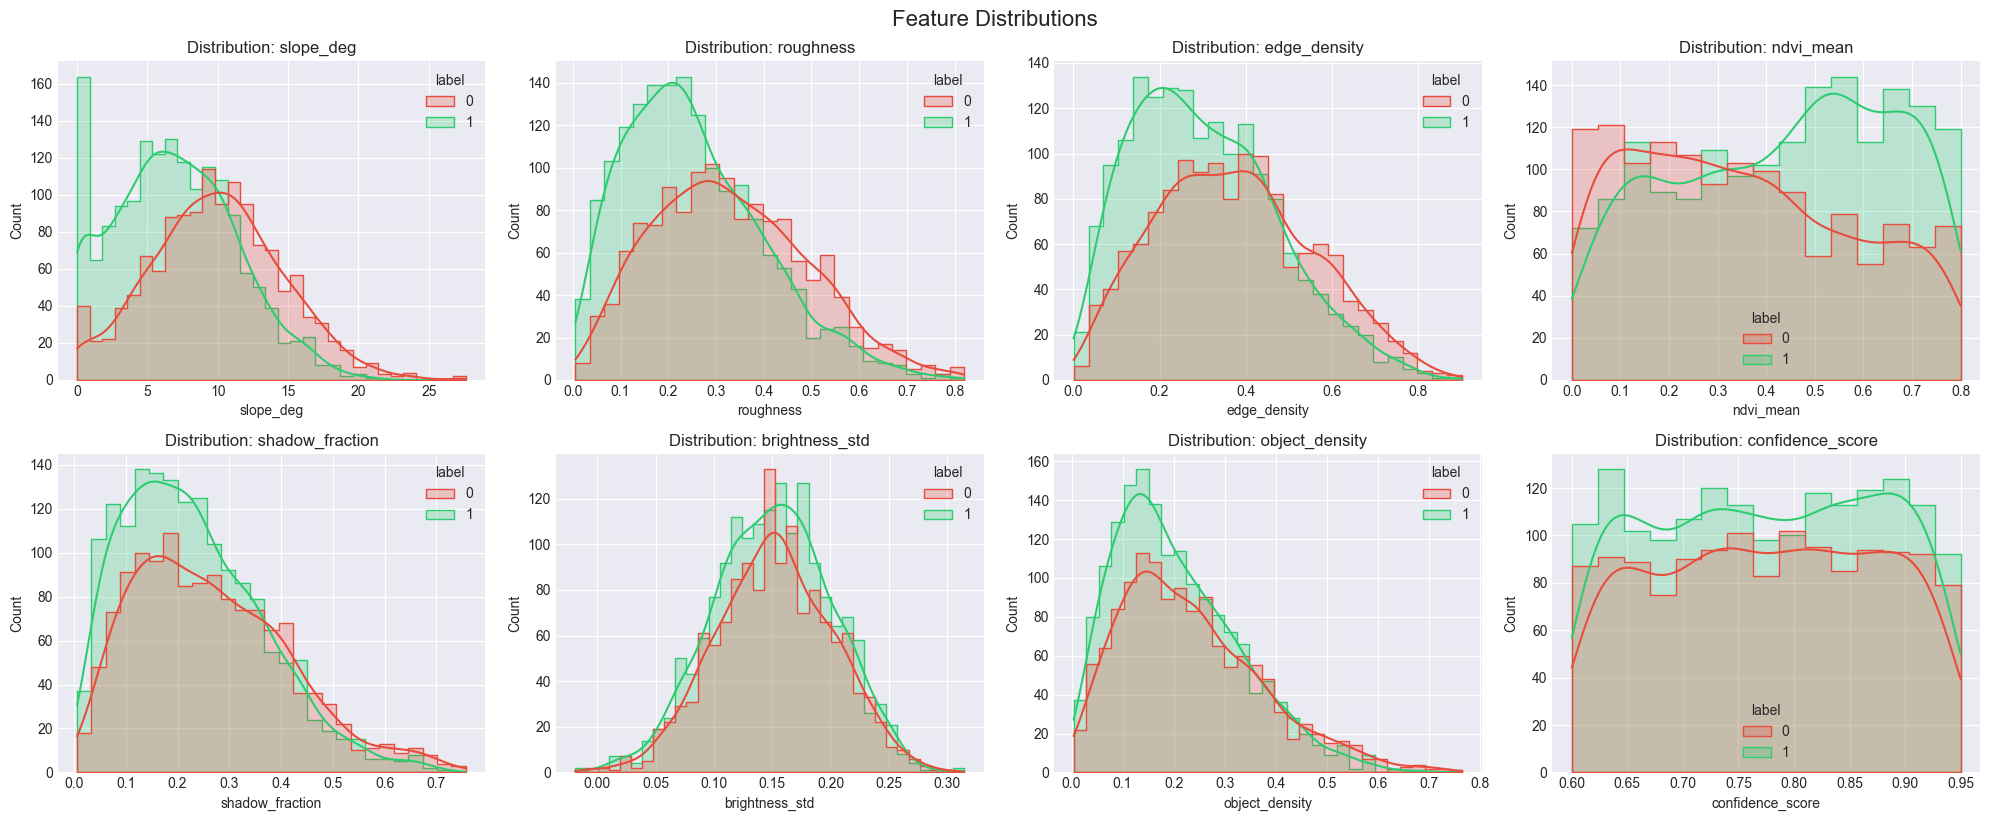

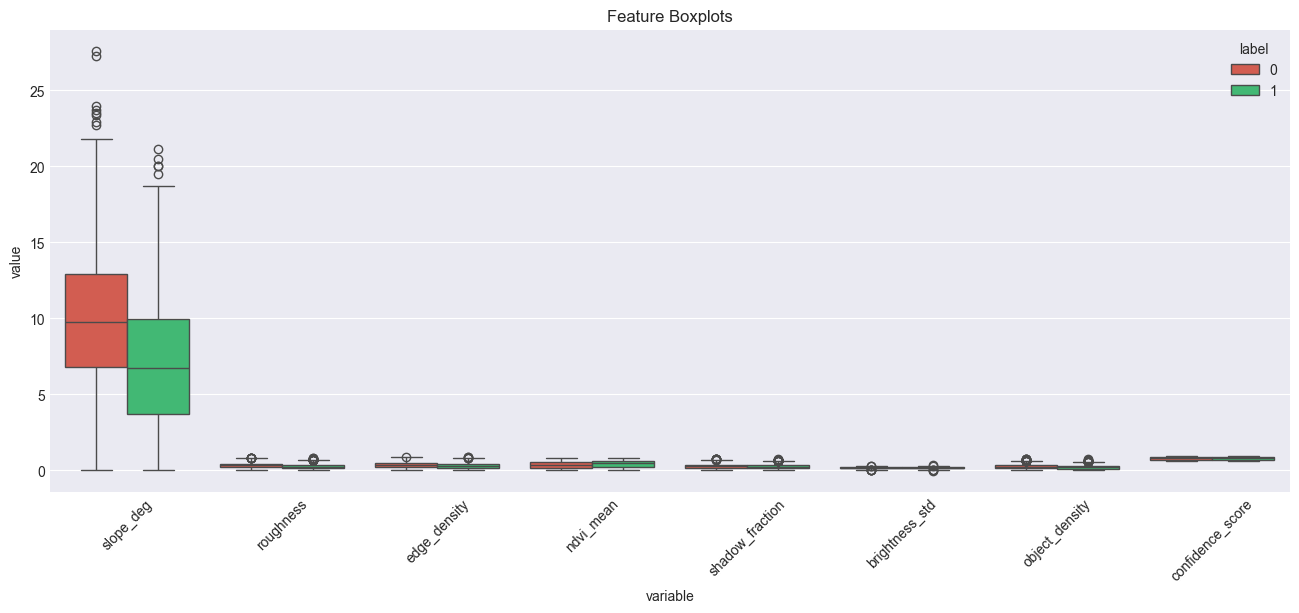

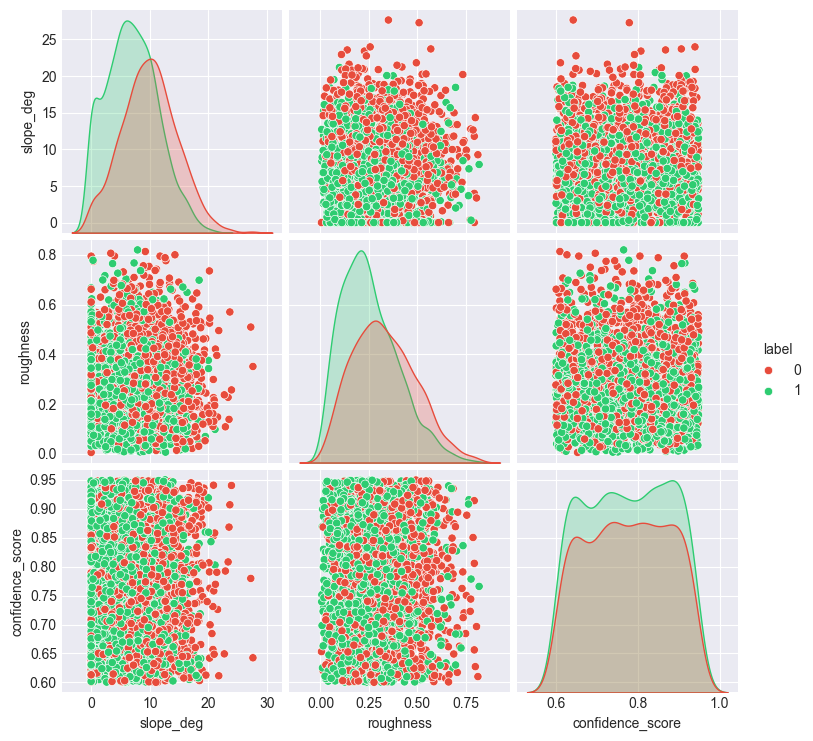

In [3]:
# Descriptive Stats
print("📊 Descriptive Statistics:")
display(df.describe().T[['mean', 'std', 'min', '50%', 'max']])

# Distributions
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    if col != 'label' and i < 8:
        sns.histplot(data=df, x=col, hue='label', kde=True, element="step", ax=axes[i], palette=['#e74c3c', '#2ecc71'])
        axes[i].set_title(f'Distribution: {col}')
plt.tight_layout()
plt.suptitle('Feature Distributions', y=1.02, fontsize=16)
plt.show()

# Boxplots
plt.figure(figsize=(16, 6))
sns.boxplot(data=df.melt(id_vars='label'), x='variable', y='value', hue='label', palette=['#e74c3c', '#2ecc71'])
plt.title('Feature Boxplots')
plt.xticks(rotation=45)
plt.show()

# Pairplot
sns.pairplot(df[['slope_deg', 'roughness', 'confidence_score', 'label']], hue='label', palette=['#e74c3c', '#2ecc71'])
plt.show()

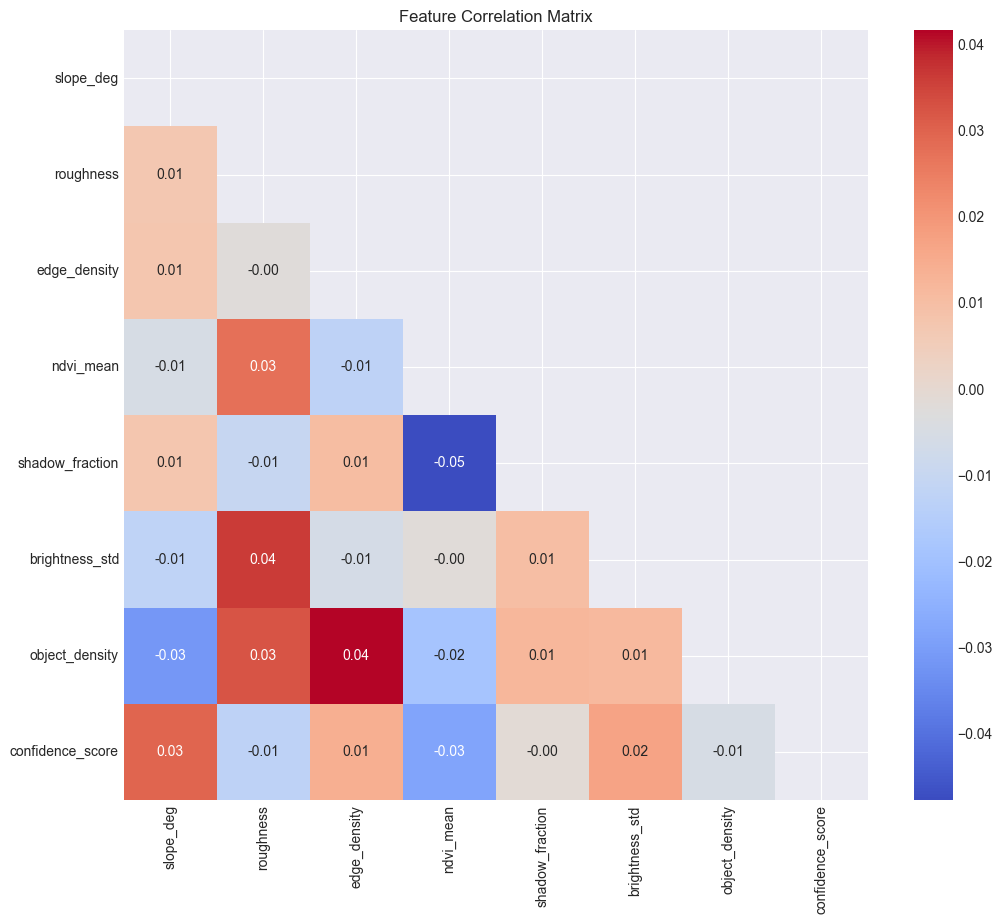

📊 Multicollinearity Check (VIF):


,feature,VIF
7,confidence_score,19.713769
5,brightness_std,9.130626
2,edge_density,4.471833
1,roughness,4.192845
0,slope_deg,3.943972
4,shadow_fraction,3.834443
3,ndvi_mean,3.813113
6,object_density,3.706716


In [4]:
# Correlation Matrix
plt.figure(figsize=(12, 10))
corr = df.drop(columns=['label']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.title('Feature Correlation Matrix')
plt.show()

# VIF
print("📊 Multicollinearity Check (VIF):")
X_vif = df.drop(columns=['label'])
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
display(vif_data.sort_values(by="VIF", ascending=False))

## 3. Feature Engineering & Selection

In [5]:
# Create Features
df['slope_roughness'] = df['slope_deg'] * df['roughness']
df['safety_index'] = df['confidence_score'] / (df['slope_deg'] + 1)
df['complexity'] = df['edge_density'] * df['object_density']

# Prepare Data
X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)

# RFE
print("🔍 Running RFE...")
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=8, step=1)
rfe.fit(X_train_sm, y_train_sm)
selected_mask = rfe.support_
selected_feats = X.columns[selected_mask]
print(f"✅ Selected Features: {list(selected_feats)}")

X_train_sm = X_train_sm[:, selected_mask]
X_test_scaled = X_test_scaled[:, selected_mask]

🔍 Running RFE...


✅ Selected Features: ['slope_deg', 'roughness', 'edge_density', 'ndvi_mean', 'shadow_fraction', 'slope_roughness', 'safety_index', 'complexity']


## 4. Multi-Model Comparison (Strict Safety First)

🚀 Training All Models (Prioritizing STRICT Zero Fatal Errors)...



🏆 Model Ranking (Safety First):


,Model,Fatal_Errors,Missed_Safe,Accuracy,Precision,Recall,F1,AUC
0,LogisticRegression,78,94,0.713333,0.751592,0.715152,0.732919,0.760034
5,GradientBoosting,81,99,0.700000,0.740385,0.700000,0.719626,0.746667
3,SVM,82,100,0.696667,0.737179,0.696970,0.716511,0.743591
1,RandomForest,83,107,0.683333,0.728758,0.675758,0.701258,0.739394
8,CatBoost,83,103,0.690000,0.732258,0.687879,0.709375,0.736970
6,AdaBoost,84,104,0.686667,0.729032,0.684848,0.706250,0.747116
4,KNN,86,108,0.676667,0.720779,0.672727,0.695925,0.699091
9,LightGBM,88,98,0.690000,0.725000,0.703030,0.713846,0.737127
2,ExtraTrees,92,103,0.675000,0.711599,0.687879,0.699538,0.736268
7,XGBoost,97,99,0.673333,0.704268,0.700000,0.702128,0.718092


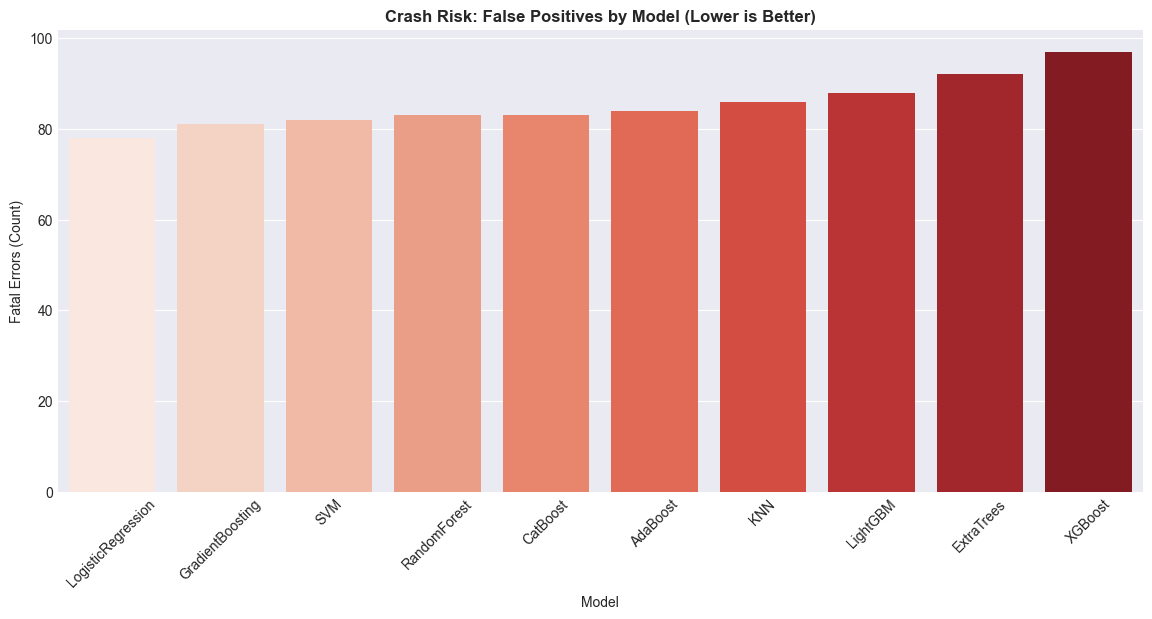


✅ JUDICIOUS SELECTION: Found 1 models with 78 Fatal Errors.
   Selected Models: ['LogisticRegression']


In [6]:
# Define Models
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Add optional models
if CATBOOST_AVAILABLE:
    models['CatBoost'] = CatBoostClassifier(verbose=0, random_state=42)
if LGBM_AVAILABLE:
    models['LightGBM'] = LGBMClassifier(random_state=42, verbose=-1)

results = []
print("🚀 Training All Models (Prioritizing STRICT Zero Fatal Errors)...")

for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate Fatal Errors (False Positives)
    # FP = Predicted Safe (1) but Actual Unsafe (0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    results.append({
        'Model': name, 
        'Fatal_Errors': fp,
        'Missed_Safe': fn,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob)
    })

# === SAFETY FIRST SELECTION ===
# Sort by Fatal Errors (Ascending) FIRST, then AUC (Descending)
results_df = pd.DataFrame(results).sort_values(by=['Fatal_Errors', 'AUC'], ascending=[True, False])

print("\n🏆 Model Ranking (Safety First):")
display(results_df)

# Visualize Fatal Errors
plt.figure(figsize=(14, 6))
sns.barplot(data=results_df, x='Model', y='Fatal_Errors', palette='Reds')
plt.title('Crash Risk: False Positives by Model (Lower is Better)', fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Fatal Errors (Count)')
plt.show()

# === CRITICAL SELECTION STEP ===
# Select ALL models that share the MINIMUM Fatal Error count.
min_fatal = results_df['Fatal_Errors'].min()
safest_models_df = results_df[results_df['Fatal_Errors'] == min_fatal]

selected_names = safest_models_df['Model'].tolist()
print(f"\n✅ JUDICIOUS SELECTION: Found {len(selected_names)} models with {min_fatal} Fatal Errors.")
print(f"   Selected Models: {selected_names}")

selected_models = {name: models[name] for name in selected_names}

## 5. Hyperparameter Tuning

In [7]:
tuned_models = []

for name, model in selected_models.items():
    print(f"⚙️ Tuning {name}...")
    
    param_grid = {}
    if 'XGB' in name:
        param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]}
    elif 'RandomForest' in name or 'ExtraTrees' in name:
        param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
    elif 'SVM' in name:
        param_grid = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}
    elif 'GradientBoosting' in name:
        param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
    elif 'KNN' in name:
        param_grid = {'n_neighbors': [3, 5, 7]}
    elif 'Logistic' in name:
        param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
    elif 'AdaBoost' in name:
        param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]}
    
    if param_grid:
        # Tuning metric: ROC_AUC is safe general proxy. 
        # Precision could also be used to target FP reduction specifically.
        rs = RandomizedSearchCV(model, param_grid, n_iter=10, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1)
        rs.fit(X_train_sm, y_train_sm)
        print(f"   ✅ Best: {rs.best_params_}")
        tuned_models.append((name, rs.best_estimator_))
    else:
        tuned_models.append((name, model))

print("\n✅ Tuning Complete.")

⚙️ Tuning LogisticRegression...


   ✅ Best: {'solver': 'lbfgs', 'C': 0.1}

✅ Tuning Complete.


## 6. Voting Ensemble (Safest Models)

🤝 Building Voting Ensemble...

📊 FINAL ENSEMBLE RESULTS:
              precision    recall  f1-score   support

      Unsafe       0.67      0.71      0.69       270
        Safe       0.75      0.72      0.73       330

    accuracy                           0.71       600
   macro avg       0.71      0.71      0.71       600
weighted avg       0.72      0.71      0.71       600

ROC-AUC: 0.7599
Ensemble Fatal Errors (False Positives): 78
CV ROC-AUC: 0.8018 ± 0.0426


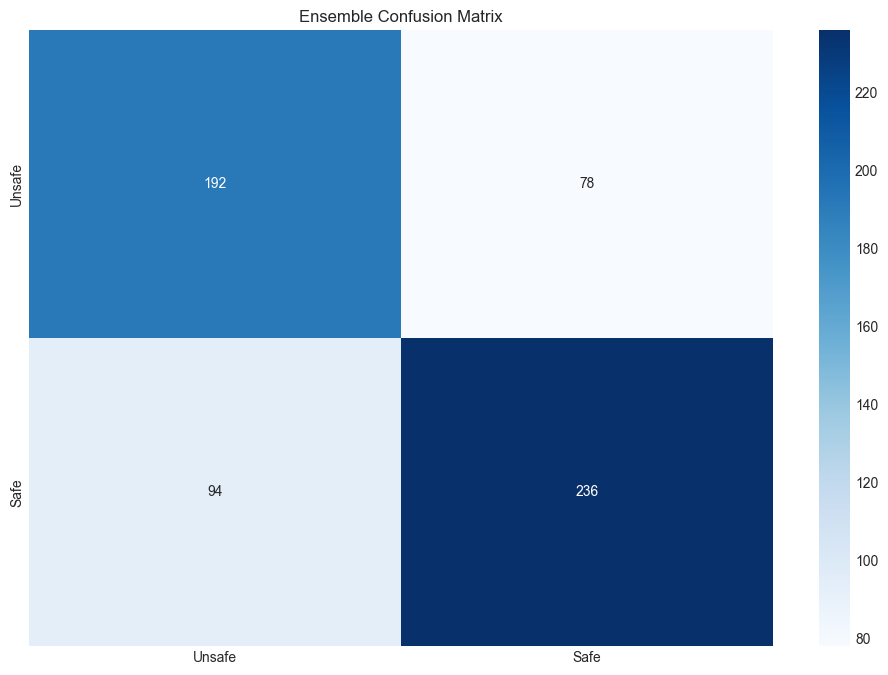

In [8]:
print("🤝 Building Voting Ensemble...")
voting_clf = VotingClassifier(estimators=tuned_models, voting='soft')
voting_clf.fit(X_train_sm, y_train_sm)

y_pred = voting_clf.predict(X_test_scaled)
y_prob = voting_clf.predict_proba(X_test_scaled)[:, 1]

print("\n📊 FINAL ENSEMBLE RESULTS:")
print(classification_report(y_test, y_pred, target_names=['Unsafe', 'Safe']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Calculate Ensemble Fatal Errors
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"Ensemble Fatal Errors (False Positives): {fp}")
if fp == 0:
    print("🌟 SUCCESS: ZERO FATAL ERRORS ACHIEVED.")

# CV
cv_scores = cross_val_score(voting_clf, X_train_sm, y_train_sm, cv=5, scoring='roc_auc')
print(f"CV ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std()*2:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsafe', 'Safe'], yticklabels=['Unsafe', 'Safe'])
plt.title('Ensemble Confusion Matrix')
plt.show()

best_model = voting_clf

## Task 3: Spatial Safety Analysis

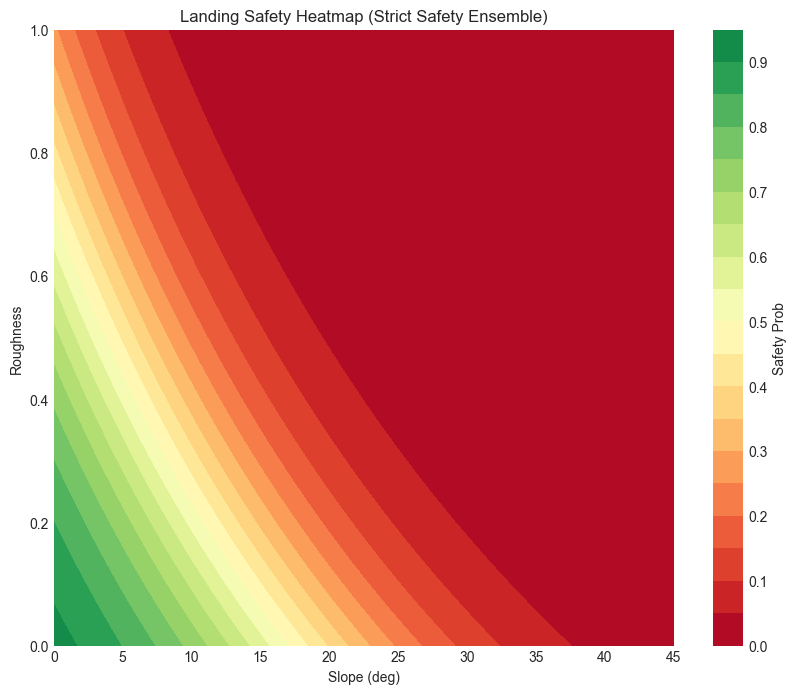

In [9]:
slope_range = np.linspace(0, 45, 100)
rough_range = np.linspace(0, 1, 100)
slope_grid, rough_grid = np.meshgrid(slope_range, rough_range)

selected_feature_names = list(selected_feats)
X_train_selected = X_train[selected_feats]
means = X_train_selected.mean()

n_points = len(slope_grid.ravel())
grid_df = pd.DataFrame({col: np.full(n_points, means[col]) for col in selected_feature_names})

if 'slope_deg' in selected_feature_names: 
    grid_df['slope_deg'] = slope_grid.ravel()
if 'roughness' in selected_feature_names: 
    grid_df['roughness'] = rough_grid.ravel()
if 'slope_roughness' in selected_feature_names:
    s_val = grid_df.get('slope_deg', slope_grid.ravel())
    r_val = grid_df.get('roughness', rough_grid.ravel())
    grid_df['slope_roughness'] = s_val * r_val

scaler_sel = StandardScaler()
scaler_sel.fit(X_train_selected)
grid_scaled = scaler_sel.transform(grid_df)

probs = best_model.predict_proba(grid_scaled)[:, 1].reshape(slope_grid.shape)

plt.figure(figsize=(10, 8))
contour = plt.contourf(slope_grid, rough_grid, probs, levels=20, cmap='RdYlGn', vmin=0, vmax=1)
plt.colorbar(contour, label='Safety Prob')
plt.title('Landing Safety Heatmap (Strict Safety Ensemble)')
plt.xlabel('Slope (deg)')
plt.ylabel('Roughness')
plt.show()

## Task 4: Drone Autonomy

In [10]:
def evaluate_landing_zone(prob, conf):
    # Strict thresholds for Safety
    if prob >= 0.90 and conf >= 0.80: return "LAND"
    elif prob >= 0.70: return "CAUTION"
    elif prob >= 0.50: return "LOITER"
    return "ABORT"

print("Simulated Decisions:")
print(f"P=0.95, C=0.85 -> {evaluate_landing_zone(0.95, 0.85)}")
print(f"P=0.75, C=0.80 -> {evaluate_landing_zone(0.75, 0.80)}")
print(f"P=0.40, C=0.90 -> {evaluate_landing_zone(0.40, 0.90)}")

Simulated Decisions:
P=0.95, C=0.85 -> LAND
P=0.75, C=0.80 -> CAUTION
P=0.40, C=0.90 -> ABORT


## Task 5: Reflection
### Data Limitations
- **Static Dataset**: Does not account for moving obstacles.
- **Optical Only**: Vulnerable to low light/weather.
### Proposed Improvements
1. **LiDAR Fusion**: For depth and night landing.
2. **VSLAM**: For real-time motion planning.
3. **Active Learning**: Query humans on edge cases.